<h1>Home Assignment #2</h1>


Remember to test your classes with some data to ensure they’re working as expected. Happy coding! 🚀

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons

Запасные блоки кода

## Task 1. Base Clustering Class (1 point)

Define a class `BaseCluster` with the following methods:
* `fit(self, data)`: This method should be implemented in each subclass.
* `predict(self, data):` This method should be implemented in each subclass.


In [ ]:
class BaseCluster:
    def fit(self, data):
        """
        Fit the clustering model to the given data.

        Parameters:
        - data: The input data for training the clustering model.
        """
        raise NotImplementedError("fit method must be implemented in each subclass.")

    def predict(self, data):
        """
        Predict the cluster labels for the given data.

        Parameters:
        - data: The input data for which to predict cluster labels.

        Returns:
        - labels: The predicted cluster labels.
        """
        raise NotImplementedError("predict method must be implemented in each subclass.")

## Task 2. KMeans (3 points)

1. Define a class `KMeans` that inherits from `BaseCluster`.
2. Implement the `fit` and `predict` methods.
3. Add a method `initialize_centroids` to initialize the centroids.


In [ ]:
class KMeansCluster(BaseCluster):
    def __init__(self, n_clusters=3, max_iterations=100):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.centroids = None
        self.labels_ = None

    def initialize_centroids(self, data):
        """
        Initialize centroids for KMeans clustering.

        Parameters:
        - data: The input data for which centroids need to be initialized.

        Returns:
        - centroids: Initialized centroids.
        """
        centroids_indices = np.random.choice(len(data), size=self.n_clusters, replace=False)
        centroids = data[centroids_indices]
        return centroids

    def fit(self, data):
        """
        Fit the KMeans clustering model to the given data.

        Parameters:
        - data: The input data for training the KMeans model.
        """
        # Initialize centroids
        self.centroids = self.initialize_centroids(data)
        self.labels_ = np.zeros(len(data))

        for _ in range(self.max_iterations):
            # Assign each data point to the nearest centroid
            self.labels_ = np.argmin(np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=-1), axis=-1)

            # Update centroids based on the mean of points assigned to each cluster
            new_centroids = np.array([np.mean(data[self.labels_ == i], axis=0) for i in range(self.n_clusters)])

            # Check for convergence
            if np.all(new_centroids == self.centroids):
                break

            self.centroids = new_centroids

    def predict(self, data):
        """
        Predict the cluster labels using the trained KMeans model.

        Parameters:
        - data: The input data for which to predict cluster labels.

        Returns:
        - labels: The predicted cluster labels.
        """
        return np.argmin(np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=-1), axis=-1)

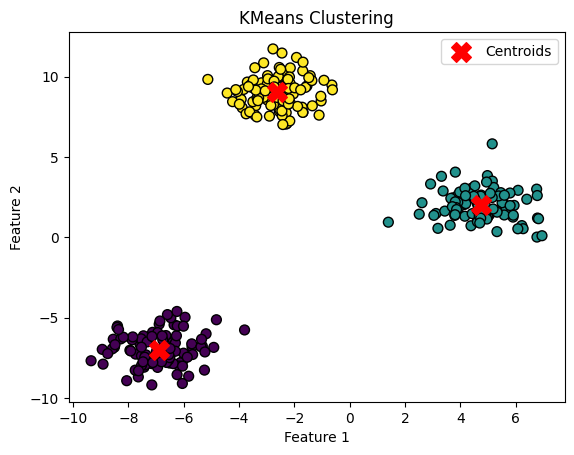

In [ ]:
# Generate some example data
data, _ = make_blobs(n_samples=300, centers=3, random_state=42)

# Create a KMeansCluster instance
kmeans_cluster = KMeansCluster(n_clusters=3, max_iterations=100)

# Fit the model to the data
kmeans_cluster.fit(data)

# Get the predicted cluster labels
predicted_labels = kmeans_cluster.predict(data)

# Visualize the results
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis', edgecolor='k', s=50)
plt.scatter(kmeans_cluster.centroids[:, 0], kmeans_cluster.centroids[:, 1], marker='X', c='red', s=200, label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

1. Define a class `KMeansPlusPlus` that inherits from `KMeans`.
2. Override the `initialize_centroids` method to use the KMeans++ initialization algorithm.


In [ ]:
class KMeansPlusPlus(KMeansCluster):
    def initialize_centroids(self, data):
        """
        Initialize centroids for KMeans++ clustering.

        Parameters:
        - data: The input data for which centroids need to be initialized.

        Returns:
        - centroids: Initialized centroids using KMeans++ algorithm.
        """
        # Randomly choose the first centroid
        centroids = [data[np.random.choice(len(data))]]

        # Choose the remaining centroids using KMeans++ algorithm
        for _ in range(1, self.n_clusters):
            distances = np.array([min(np.linalg.norm(x - c) for c in centroids) for x in data])
            probabilities = distances / distances.sum()
            new_centroid_index = np.random.choice(len(data), p=probabilities)
            centroids.append(data[new_centroid_index])

        return np.array(centroids)

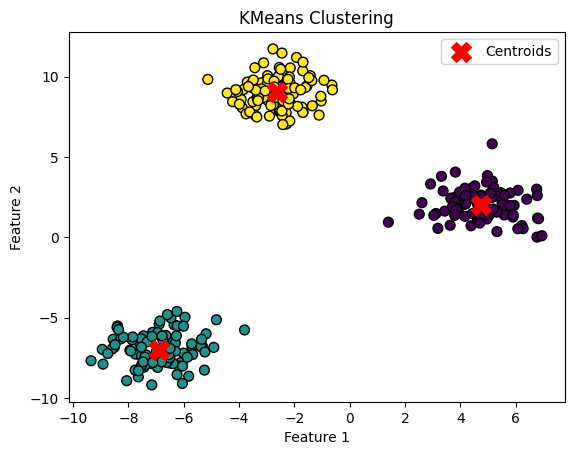

In [ ]:
# Create a KMeansCluster instance
kmeans_cluster_plus = KMeansPlusPlus(n_clusters=3, max_iterations=100)

# Fit the model to the data
kmeans_cluster.fit(data)

# Get the predicted cluster labels
predicted_labels = kmeans_cluster.predict(data)

# Visualize the results
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis', edgecolor='k', s=50)
plt.scatter(kmeans_cluster.centroids[:, 0], kmeans_cluster.centroids[:, 1], marker='X', c='red', s=200, label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## Task 3. DBSCAN (3 points)

1. Define a class `DBSCAN` that inherits from `BaseCluster`.
2. Implement the `fit` and `predict` methods.
3. Add a method `region_query` to return the point neighbors within a certain radius.

In [ ]:
class DBSCAN(BaseCluster):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def region_query(self, data, point_index):
        """
        Return the indices of points within the epsilon radius of a given point.

        Parameters:
        - data: The input data.
        - point_index: Index of the point for which neighbors are to be found.

        Returns:
        - neighbors: Indices of points within the epsilon radius.
        """
        distances = np.linalg.norm(data - data[point_index], axis=1)
        return np.where(distances <= self.eps)[0]

    def expand_cluster(self, data, point_index, cluster_label, visited):
        """
        Recursively expand the cluster starting from a given point.

        Parameters:
        - data: The input data.
        - point_index: Index of the starting point.
        - neighbors: Indices of points within the epsilon radius.
        - cluster_label: Current cluster label.
        - visited: Array to track visited points.
        """
        visited[point_index] = True
        self.labels_[point_index] = cluster_label

        neighbors = self.region_query(data, point_index)

        for neighbor_index in neighbors:
            if not visited[neighbor_index]:
                self.expand_cluster(data, neighbor_index, cluster_label, visited)

    def fit(self, data):
        """
        Fit the DBSCAN clustering model to the given data.

        Parameters:
        - data: The input data for training the DBSCAN model.
        """
        n_samples = len(data)
        self.labels_ = np.full(n_samples, -1)  # -1 represents noise points
        visited = np.full(n_samples, False)

        current_cluster = 0

        for point_index in range(n_samples):
            if visited[point_index]:
                continue

            neighbors = self.region_query(data, point_index)

            if len(neighbors) < self.min_samples:
                self.labels_[point_index] = -1  # Mark as noise
            else:
                current_cluster += 1
                self.expand_cluster(data, point_index, current_cluster, visited)

    def predict(self, data):
        """
        Predict the cluster labels using the trained DBSCAN model.

        Parameters:
        - data: The input data for which to predict cluster labels.

        Returns:
        - labels: The predicted cluster labels.
        """
        return self.labels_

2


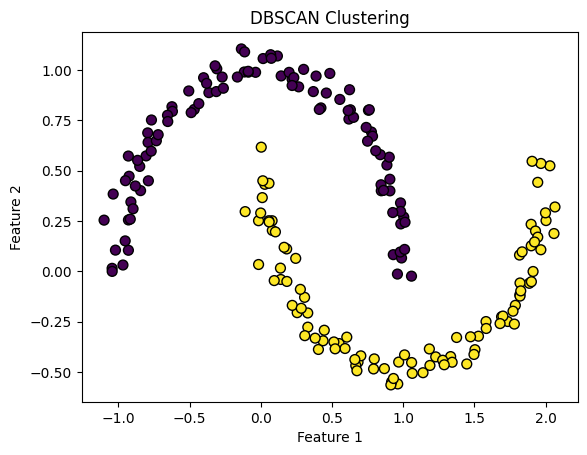

In [ ]:
# Generate some example data
data, _ = make_moons(n_samples=200, noise=0.05, random_state=42)

# Create a DBSCAN instance
dbscan_cluster = DBSCAN(eps=0.3, min_samples=5)

# Fit the model to the data
dbscan_cluster.fit(data)

# Get the predicted cluster labels
predicted_labels = dbscan_cluster.predict(data)
print(len(np.unique(predicted_labels)))

# Visualize the results
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Task 4. Agglomerative Clustering (3 points)

1. Define a class `AgglomerativeClustering` that inherits from `BaseCluster`.
2. Implement the `fit` and `predict` methods.
3. Add methods `single_linkage`, `complete_linkage`, and `average_linkage` to implement the three ways to merge clusters.


In [ ]:
class AgglomerativeClustering(BaseCluster):
    def __init__(self, n_clusters=2, linkage='single'):
        self.linkage = linkage
        self.n_clusters = n_clusters
        self.labels_ = None

    def fit(self, X):
        # Initialize clusters
        clusters = [{i} for i in range(len(X))]

        while len(clusters) > self.n_clusters:
            # Find closest clusters
            i, j = self._find_closest_clusters(X, clusters)

            # Merge clusters
            clusters[i].update(clusters[j])
            del clusters[j]

        # Assign labels
        self.labels_ = np.zeros(len(X), dtype=int)
        for label, cluster in enumerate(clusters):
            self.labels_[list(cluster)] = label

    def predict(self, X):
        return self.labels_

    def single_linkage(self, cluster1, cluster2, X):
        # Calculate single linkage distance between two clusters
        min_distance = np.inf
        for i in cluster1:
            for j in cluster2:
                distance = np.linalg.norm(X[i] - X[j])  # Euclidean distance
                min_distance = min(min_distance, distance)
        return min_distance

    def complete_linkage(self, cluster1, cluster2, X):
        # Calculate complete linkage distance between two clusters
        max_distance = -np.inf
        for i in cluster1:
            for j in cluster2:
                distance = np.linalg.norm(X[i] - X[j])  # Euclidean distance
                max_distance = max(max_distance, distance)
        return max_distance

    def average_linkage(self, cluster1, cluster2, X):
        # Calculate average linkage distance between two clusters
        total_distance = 0
        count = 0
        for i in cluster1:
            for j in cluster2:
                distance = np.linalg.norm(X[i] - X[j])  # Euclidean distance
                total_distance += distance
                count += 1
        return total_distance / count

    def _find_closest_clusters(self, X, clusters):
        # Find the indices of the two closest clusters based on the chosen linkage method
        min_distance = np.inf
        closest_i, closest_j = 0, 0

        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                if self.linkage == 'single':
                    distance = self.single_linkage(clusters[i], clusters[j], X)
                elif self.linkage == 'complete':
                    distance = self.complete_linkage(clusters[i], clusters[j], X)
                elif self.linkage == 'average':
                    distance = self.average_linkage(clusters[i], clusters[j], X)
                else:
                    raise ValueError("Invalid linkage method. Use 'single', 'complete', or 'average'.")

                if distance < min_distance:
                    min_distance = distance
                    closest_i, closest_j = i, j

        return closest_i, closest_j

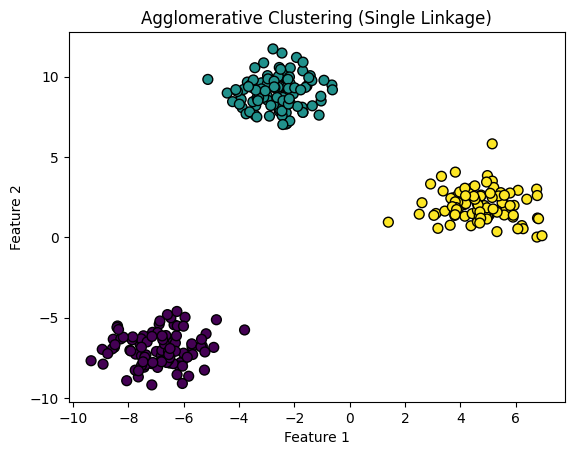

In [ ]:
# Generate some example data
data, _ = make_blobs(n_samples=300, centers=3, random_state=42)

agglomerative_cluster = AgglomerativeClustering(n_clusters=3, linkage='single')
agglomerative_cluster.fit(data)
predicted_labels = agglomerative_cluster.predict(data)

# Visualize the results
plt.scatter(data[:, 0], data[:, 1], c=predicted_labels, edgecolor='k', s=50)
plt.title('Agglomerative Clustering (Single Linkage)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()